In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [2]:
from py4DSTEM.file.io import FileBrowser

In [3]:
fp = "/Users/Ben/Desktop/01_Elastomer_braggvectormap.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    braggvectormap_shiftcorrected       DiffractionSlice    


In [4]:
bvm = browser.get_dataobject('braggvectormap_shiftcorrected').data
browser.close()

Q_Nx,Q_Ny = bvm.shape

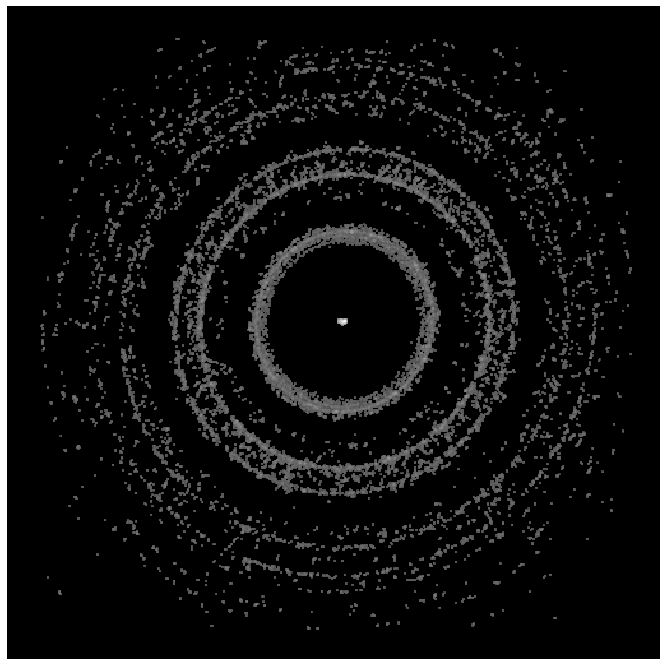

In [5]:
power = 0.07

fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(bvm**power)
ax.axis('off')
plt.show()

### Fit an ellipse

In [6]:
from matplotlib.patches import Circle, Ellipse
from scipy.ndimage.filters import gaussian_filter
from py4DSTEM.process.utils import fit_ellipse_inside_annulus

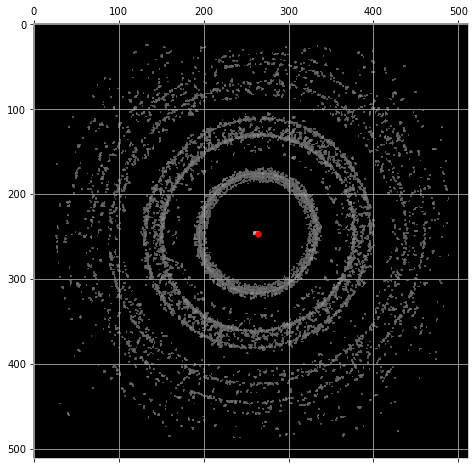

In [7]:
# Find center

power = 0.07

x0,y0 = np.unravel_index(np.argmax(gaussian_filter(bvm,2)),(Q_Nx,Q_Ny))

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(bvm**power)
ax.scatter(y0,x0,color='r')
plt.show()

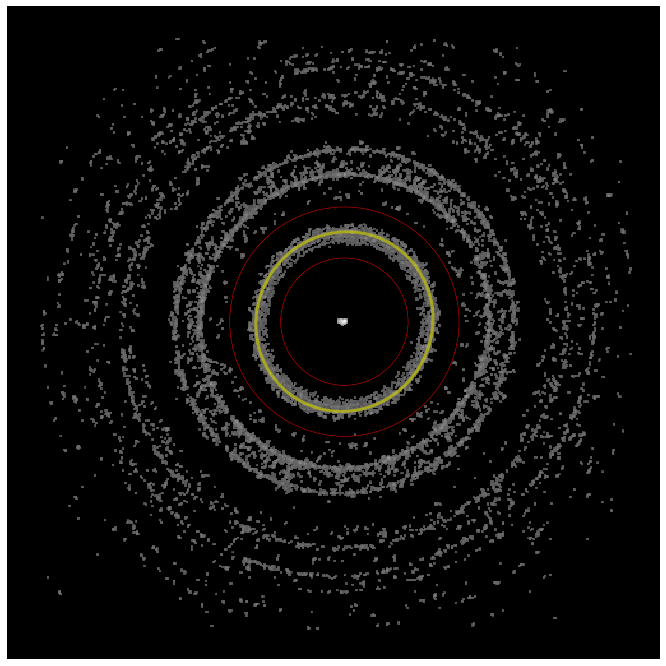

In [8]:
# Fit an ellipse

# r_inner = 100
# r_outer = 125
r_inner = 50
r_outer = 90

ellipse_params = fit_ellipse_inside_annulus(bvm, x0, y0, r_inner, r_outer)
x0_,y0_,A_,B_,phi_ = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(bvm**power)
circle_inner = Circle((y0_,x0_),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0_,x0_),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y0_,x0_),2*A_,2*B_,90-np.degrees(phi_), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
ax.axis('off')
plt.show()

In [9]:
print("{:.2f}% elliptical distortion".format(100*(1-B_/A_)))

3.35% elliptical distortion


### Polar Elliptical transform

In [36]:
from py4DSTEM.process.utils import cartesianDataAr_to_polarEllipticalDataAr

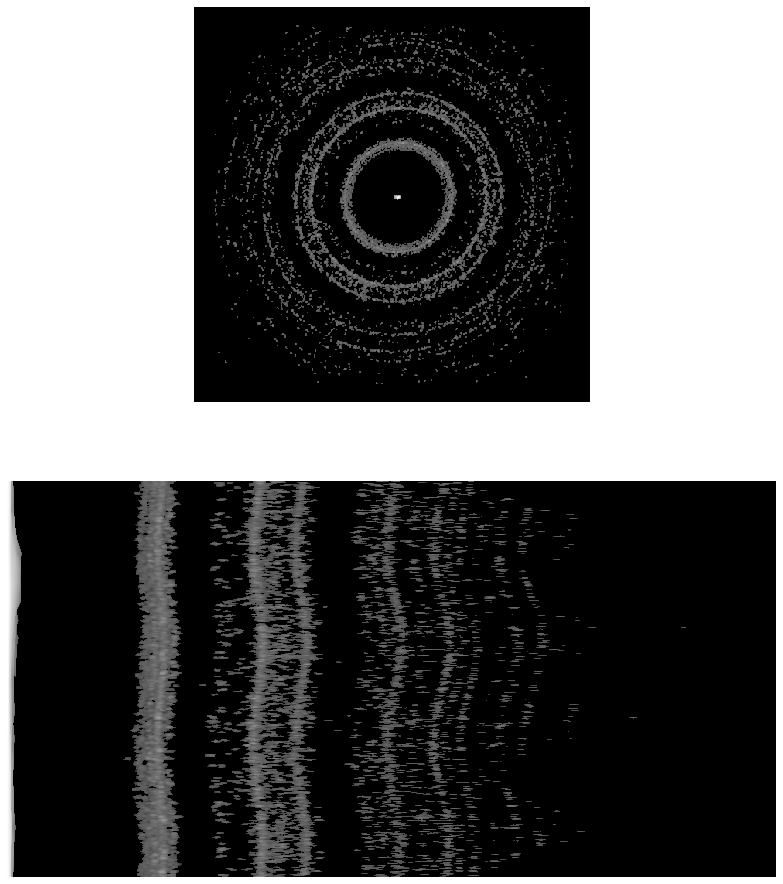

In [54]:
# Polar transform (i.e. A=B)
ellipse_params = (x0_,y0_,1,1,0)

polarData,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                    cartesianData=bvm,
                    params=ellipse_params,
                    dr=.25,
                    r_range=350,
                    dtheta=np.radians(0.5),
                    mask=None
)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,16))
ax1.matshow(bvm**power)
ax2.matshow(polarData.data**power)
ax1.axis('off')
ax2.axis('off')
plt.show()

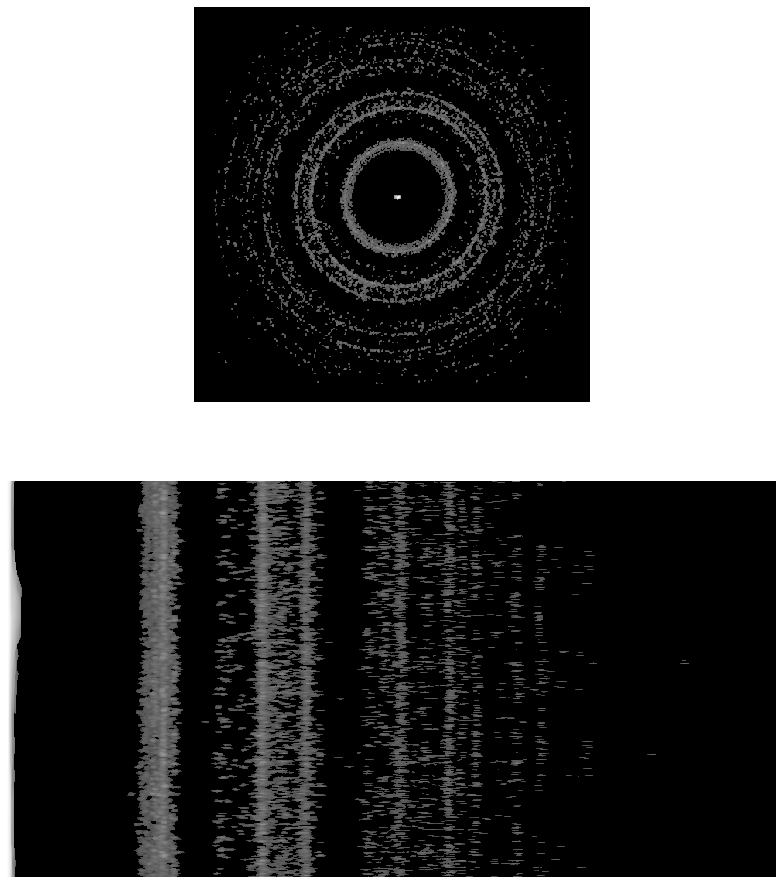

In [55]:
# Polar-elliptical transform

ellipse_params = (x0_,y0_,1,B_/A_,phi_)

polarEllipticalData,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                                    cartesianData=bvm,
                                    params=ellipse_params,
                                    dr=.25,
                                    r_range=350,
                                    dtheta=np.radians(0.5),
                                    mask=None
)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,16))
ax1.matshow(bvm**power)
ax2.matshow(polarEllipticalData.data**power)
ax1.axis('off')
ax2.axis('off')
plt.show()

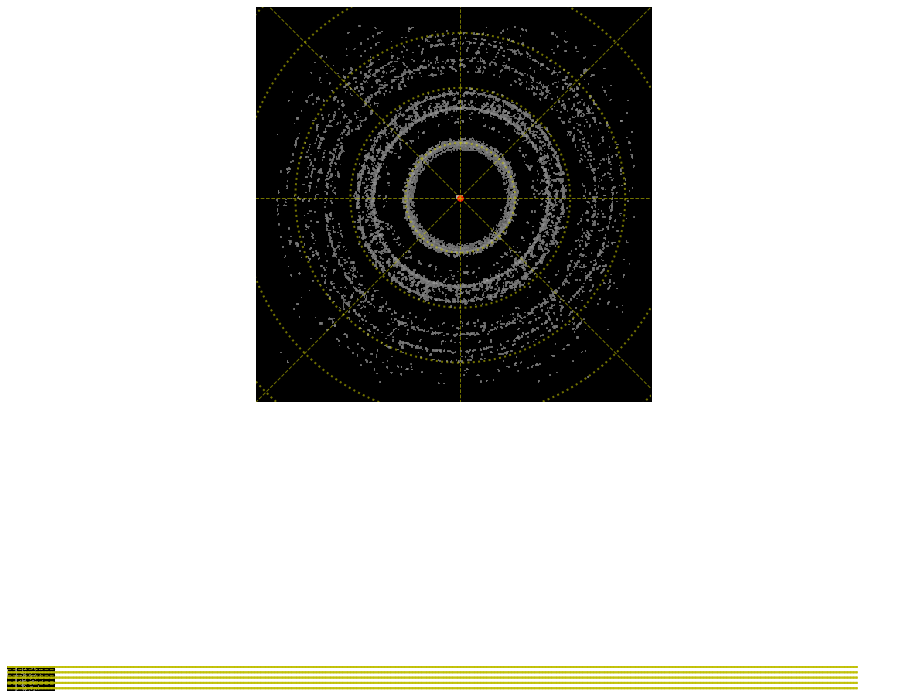

In [71]:
# Polar transform, with coordinate lines

r_vals = np.linspace(0,5,6)
circles = []
for i,r_val in enumerate(r_vals):
    circle = Circle((y0_,x0_),r_val*A_, fill=False,ec='y',ls=":",lw=2, alpha=.6)
    circles.append(circle)

def get_xfyf(x0,y0,theta):
    R = 600
    xf = x0 + A_*R*np.cos(theta)
    yf = y0 + A_*R*np.sin(theta)
    return xf,yf

Nt,Nr = polarData.data.shape
    
# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,16))
ax1.scatter(y0_,x0_,color='r')
for circle in circles:
    ax1.add_patch(circle)
for theta in np.linspace(0,2*np.pi,8,endpoint=False):
    xf,yf = get_xfyf(x0_,y0_,theta)
    ax1.plot((y0_,yf),(x0_,xf),color='y',lw=1,ls='--',alpha=0.6)
ax1.matshow(bvm**power)
ax1.axis('off')

ax2.matshow(polarData.data**power)
ax2.hlines(np.linspace(0,Nt,8,endpoint=False),0,Nr,color='y',lw=1,ls='--',alpha=0.6)
ax2.vlines(np.array(r_vals)*A_,0,Nt,color='y',ls=":",lw=2, alpha=0.6)
ax2.axis('off')
plt.show()

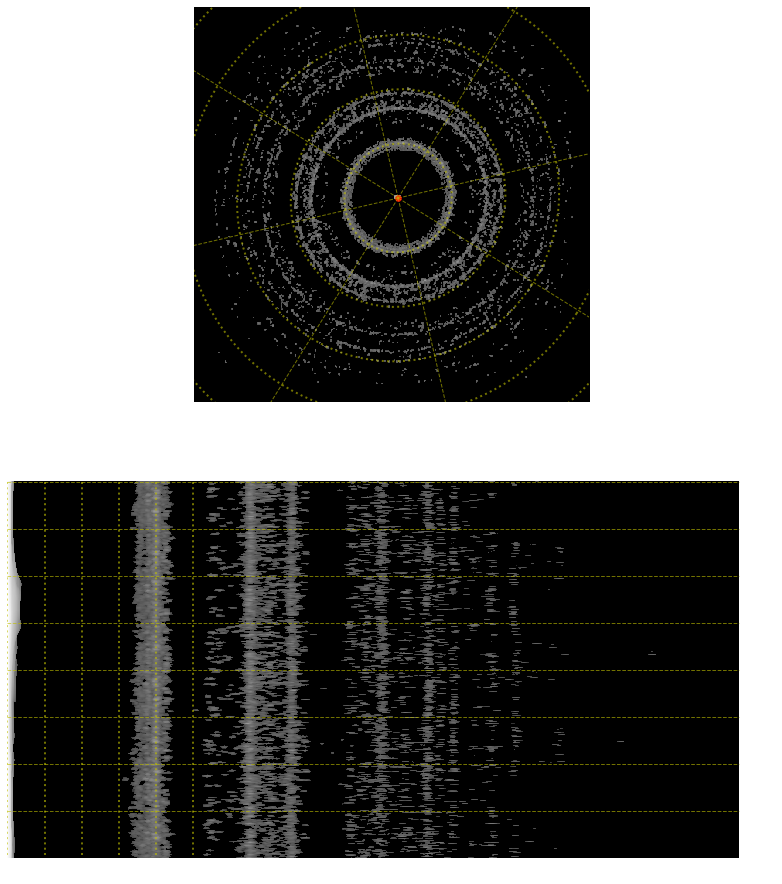

In [58]:
# Polar-elliptical transform, with coordinate lines

r_vals = np.linspace(0,5,6)
ellipses = []
for i,r_val in enumerate(r_vals):
    ellipse = Ellipse((y0_,x0_),r_val*2*A_,r_val*2*B_,90-np.degrees(phi_), fill=False,ec='y',ls=":",lw=2, alpha=.6)
    ellipses.append(ellipse)

def get_xfyf(x0,y0,theta,phi):
    R = 600
    xf = x0 + A_*R*np.cos(theta)*np.cos(phi) - B_*R*np.sin(theta)*np.sin(phi)
    yf = y0 + B_*R*np.cos(theta)*np.sin(phi) + A_*R*np.sin(theta)*np.cos(phi)
    return xf,yf

Nt,Nr = polarEllipticalData.data.shape
    
# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(16,16))
ax1.scatter(y0_,x0_,color='r')
for ellipse in ellipses:
    ax1.add_patch(ellipse)
for theta in np.linspace(0,2*np.pi,8,endpoint=False):
    xf,yf = get_xfyf(x0_,y0_,theta,phi_)
    ax1.plot((y0_,yf),(x0_,xf),color='y',lw=1,ls='--',alpha=0.6)
ax1.matshow(bvm**power)
ax1.axis('off')

ax2.matshow(polarEllipticalData.data**power)
ax2.hlines(np.linspace(0,Nt,8,endpoint=False),0,Nr,color='y',lw=1,ls='--',alpha=0.6)
ax2.vlines(np.array(r_vals)*A_,0,Nt,color='y',ls=":",lw=2, alpha=0.6)
ax2.axis('off')
plt.show()

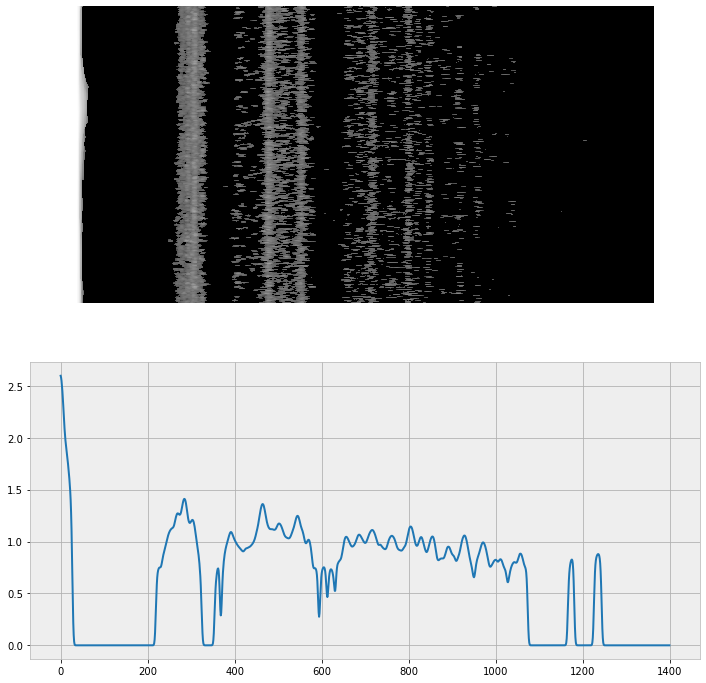

In [66]:
# radial integral

sigma=2

radial_integral = np.mean(polarEllipticalData,axis=0)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(polarEllipticalData.data**power)
ax2.plot(np.arange(len(radial_integral)),gaussian_filter(radial_integral**power,sigma))
ax1.axis('off')
plt.show()

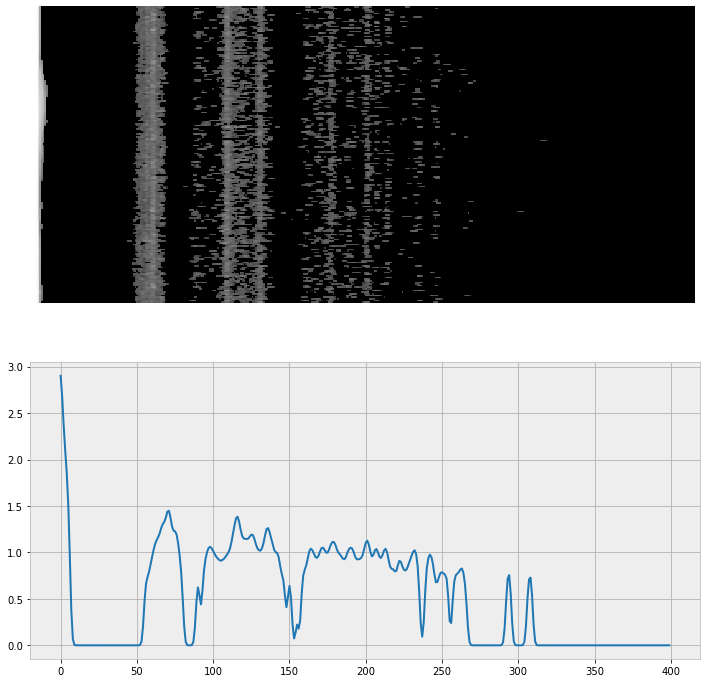

In [23]:
# radial integral

sigma=1

radial_integral = np.mean(polarEllipticalData,axis=0)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(polarEllipticalData.data**power)
ax2.plot(np.arange(len(radial_integral)),gaussian_filter(radial_integral**power,sigma))
ax1.axis('off')
plt.show()